<목차>
- RUNNER개요
- A beginer-friendly example - Runner 클래스를 선언하고, 객체를 만들고 .train() 매소드를 호출
- registry에 등록한 모델 vs 그렇지 않은 모델 사용시 (model= 에 모델 객체를 바로 넣는다)
    - Q. Runner도 결국엔 클래스인데 dict 형태로 선언하는 이유는?
- custom_config.py를 읽어서 Runner를 선언하는 방법
- 기본 데이터 흐름(Basic dataflow)

### RUNNER 개요
- MMEngine의 'integrator'인 runner는 프레임워크 모든 부분을 담당한다.
- 본 튜토리얼 이후에는 아래 사항을 익히게 된다.
    - runner의 일반적인 사용과 설정을 이해
    - runner의 config 파익 작성 방법을 이해
    - 기본적인 데이터 흐름과 실행의 이해
    - runner를 사용함으로 인한 장점을 체감
- 모든 Runner의 argument는 다음을 참고(https://mmengine.readthedocs.io/en/latest/api/generated/mmengine.runner.Runner.html#mmengine.runner.Runner)

#### A beginer-friendly example

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

from mmengine.model import BaseModel
from mmengine.evaluator import BaseMetric
from mmengine.registry import MODELS, DATASETS, METRICS


@MODELS.register_module()
class MyAwesomeModel(BaseModel):
    def __init__(self, layers=4, activation='relu') -> None:
        super().__init__()
        if activation == 'relu':
            act_type = nn.ReLU
        elif activation == 'silu':
            act_type = nn.SiLU
        elif activation == 'none':
            act_type = nn.Identity
        else:
            raise NotImplementedError
        sequence = [nn.Linear(2, 64), act_type()]
        for _ in range(layers-1):
            sequence.extend([nn.Linear(64, 64), act_type()])
        self.mlp = nn.Sequential(*sequence)
        self.classifier = nn.Linear(64, 2)

    def forward(self, data, labels, mode):
        x = self.mlp(data)
        x = self.classifier(x)
        if mode == 'tensor':
            return x
        elif mode == 'predict':
            return F.softmax(x, dim=1), labels
        elif mode == 'loss':
            return {'loss': F.cross_entropy(x, labels)}


@DATASETS.register_module()
class MyDataset(Dataset):
    def __init__(self, is_train, size):
        self.is_train = is_train
        if self.is_train:
            torch.manual_seed(0)
            self.labels = torch.randint(0, 2, (size,))
        else:
            torch.manual_seed(3407)
            self.labels = torch.randint(0, 2, (size,))
        r = 3 * (self.labels+1) + torch.randn(self.labels.shape)
        theta = torch.rand(self.labels.shape) * 2 * torch.pi
        self.data = torch.vstack([r*torch.cos(theta), r*torch.sin(theta)]).T

    def __getitem__(self, index):
        return self.data[index], self.labels[index]

    def __len__(self):
        return len(self.data)


@METRICS.register_module()
class Accuracy(BaseMetric):
    def __init__(self):
        super().__init__()

    def process(self, data_batch, data_samples):
        score, gt = data_samples
        self.results.append({
            'batch_size': len(gt),
            'correct': (score.argmax(dim=1) == gt).sum().cpu(),
        })

    def compute_metrics(self, results):
        total_correct = sum(r['correct'] for r in results)
        total_size = sum(r['batch_size'] for r in results)
        return dict(accuracy=100*total_correct/total_size)

In [5]:
from torch.utils.data import DataLoader, default_collate
from torch.optim import Adam
from mmengine.runner import Runner

runner = Runner(
    # your model
    model=MyAwesomeModel(
        layers=2,
        activation='relu'),
    # work directory for saving checkpoints and logs
    work_dir='./exp/my_awesome_model',

    # training data
    train_dataloader=DataLoader(
        dataset=MyDataset(is_train=True, size=10000),
        shuffle=True,
        collate_fn=default_collate,
        batch_size=64,
        pin_memory=True,
        num_workers=2),

    # training configurations
    train_cfg=dict(
        by_epoch=True,   # display in epoch number instead of iterations
        max_epochs=10,
        val_begin=2,     # start validation from the 2nd epoch
        val_interval=1), # do validation every 1 epoch    

    # OptimizerWrapper
    # MMEngine의 최적화를 더 정교화하기 위한 컨샙
    # Default value works fine for most cases. You may check our documentations
    # for more details, e.g. 'AmpOptimWrapper' for enabling mixed precision
    # training.
    optim_wrapper=dict(
        optimizer=dict(
            type=Adam,
            lr=0.001)),

     # ParamScheduler to adjust learning rates or momentums during training
    param_scheduler=dict(
        type='MultiStepLR',
        by_epoch=True,
        milestones=[4, 8],
        gamma=0.1),

    # validation data
    val_dataloader=DataLoader(
        dataset=MyDataset(
            is_train=False,
            size=1000),
        shuffle=False,
        collate_fn=default_collate,
        batch_size=1000,
        pin_memory=True,
        num_workers=2),
    
    # validation configurations, usually leave it an empty dict
    val_cfg=dict(),
    # evaluation metrics and evaluator
    val_evaluator=dict(type=Accuracy),

    # hook은 상위 설정. 왠만하면 default로 설정하라.
    default_hooks=dict(
        # the most commonly used hook for modifying checkpoint saving interval
        checkpoint=dict(type='CheckpointHook', interval=1)),

    # `launcher` and `env_cfg` responsible for distributed environment
    launcher='none',
    env_cfg = dict(
        cudnn_benchmark=False,
        backend='nccl',
        mp_cfg=dict(mp_start_method='fork')
    ),
    log_level='INFO',

    # load model weights from given path. None for no loading.
    load_from=None,
    # resume training from the given path
    resume=False
)

runner.train()

10/29 15:12:32 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: win32
    Python: 3.8.17 (default, Jul  5 2023, 20:44:21) [MSC v.1916 64 bit (AMD64)]
    CUDA available: True
    numpy_random_seed: 836279655
    GPU 0: NVIDIA GeForce RTX 3060 Ti
    CUDA_HOME: C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.8
    NVCC: Cuda compilation tools, release 11.8, V11.8.89
    MSVC: n/a, reason: fileno
    PyTorch: 2.0.0+cu118
    PyTorch compiling details: PyTorch built with:
  - C++ Version: 199711
  - MSVC 193431937
  - Intel(R) Math Kernel Library Version 2020.0.2 Product Build 20200624 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 2019
  - LAPACK is enabled (usually provided by MKL)
  - CPU capability usage: AVX2
  - CUDA Runtime 11.8
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,cod

RuntimeError: DataLoader worker (pid(s) 17788, 7416) exited unexpectedly

#### registry에 등록한 모델 vs 그렇지 않은 모델 사용시
- 레지스트리에 등록하지 않은 모델 사용시에 model= 인자에 객체를 바로 대입하면 된다.
- 전자(레지스트리에 등록한 모델 사용법)은 runner가 모델 사용시에 빌드하는 것이고, 후자(runner에 모델 객체 전달)은 모델이 빌드되고 runner에 전달된다.
- 아래 그림에 따르면,
    - 레지스트리에 등록된 모델은 {'모델 이름 문자열'}: {'클래스 타입'} 으로 매핑되어, Registry 클래스의 self.mapping 딕셔너리에 저장되게 되고
    - Runner가 모델 빌드시에 Registry 클래스 self.mapping 멤버에서 {'모델 이름 문자열'}로 찾는다.

![image.png](https://user-images.githubusercontent.com/112053249/199191651-44174d17-0fc5-4443-8d15-76f561ec0585.png)

In [7]:
from torch.utils.data import DataLoader, default_collate
from torch.optim import Adam
from mmengine.runner import Runner

@MODELS.register_module()
class MyAwesomeModel2(BaseModel):
    def __init__(self, layers=4, activation='relu') -> None:
        super().__init__()
        act_type = nn.ReLU
        sequence = [nn.Linear(2, 64), act_type()]
        for _ in range(layers-1):
            sequence.extend([nn.Linear(64, 64), act_type()])
        self.mlp = nn.Sequential(*sequence)
        self.classifier = nn.Linear(64, 2)

    def forward(self, data, labels, mode):
        x = self.mlp(data)
        x = self.classifier(x)
        if mode == 'tensor':
            return x
        elif mode == 'predict':
            return F.softmax(x, dim=1), labels
        elif mode == 'loss':
            return {'loss': F.cross_entropy(x, labels)}

runner = Runner(
    # your model
    model=MyAwesomeModel2(   # 클래스를 넣거나
        layers=2,
        activation='relu'),
    # work directory for saving checkpoints and logs
    work_dir='./exp/my_awesome_model'
)

10/29 15:19:50 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: win32
    Python: 3.8.17 (default, Jul  5 2023, 20:44:21) [MSC v.1916 64 bit (AMD64)]
    CUDA available: True
    numpy_random_seed: 699370593
    GPU 0: NVIDIA GeForce RTX 3060 Ti
    CUDA_HOME: C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.8
    NVCC: Cuda compilation tools, release 11.8, V11.8.89
    MSVC: n/a, reason: fileno
    PyTorch: 2.0.0+cu118
    PyTorch compiling details: PyTorch built with:
  - C++ Version: 199711
  - MSVC 193431937
  - Intel(R) Math Kernel Library Version 2020.0.2 Product Build 20200624 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 2019
  - LAPACK is enabled (usually provided by MKL)
  - CPU capability usage: AVX2
  - CUDA Runtime 11.8
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,cod

In [9]:
# 레지스트리에 등록하지 않은 모델 사용시에
class MyAwesomeModel3(BaseModel):
    def __init__(self, layers=4) -> None:
        super().__init__()
        act_type = nn.ReLU
        sequence = [nn.Linear(2, 64), act_type()]
        for _ in range(layers-1):
            sequence.extend([nn.Linear(64, 64), act_type()])
        self.mlp = nn.Sequential(*sequence)
        self.classifier = nn.Linear(64, 2)

    def forward(self, data, labels, mode):
        x = self.mlp(data)
        x = self.classifier(x)
        if mode == 'tensor':
            return x
        elif mode == 'predict':
            return F.softmax(x, dim=1), labels
        elif mode == 'loss':
            return {'loss': F.cross_entropy(x, labels)}

model = MyAwesomeModel3(layers=18)
runner = Runner(
    # your model
    model=model,     # 객체를 넣거나
    # work directory for saving checkpoints and logs
    work_dir='./exp/my_awesome_model'
)

10/29 15:20:59 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: win32
    Python: 3.8.17 (default, Jul  5 2023, 20:44:21) [MSC v.1916 64 bit (AMD64)]
    CUDA available: True
    numpy_random_seed: 812740222
    GPU 0: NVIDIA GeForce RTX 3060 Ti
    CUDA_HOME: C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.8
    NVCC: Cuda compilation tools, release 11.8, V11.8.89
    MSVC: n/a, reason: fileno
    PyTorch: 2.0.0+cu118
    PyTorch compiling details: PyTorch built with:
  - C++ Version: 199711
  - MSVC 193431937
  - Intel(R) Math Kernel Library Version 2020.0.2 Product Build 20200624 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 2019
  - LAPACK is enabled (usually provided by MKL)
  - CPU capability usage: AVX2
  - CUDA Runtime 11.8
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,cod

Q. Runner도 결국엔 클래스인데 dict 형태로 선언하는 이유는?
- 레지스트리를 통한 모듈 저장은 configuration 파일과 결합될 때 가장 큰 장점을 발휘한다.
- RUNNER도 레지스트리(@RUNNERS.register_module())에 등록되어 있고, Model과 마찬가지로 클래스 형태이다.

#### custom_config.py를 읽어서 Runner를 선언하는 방법
- config.py 파일 설정시, Adam 등은 mmengine.optim에 등록되어 있다. 따라서, 수동으로 등록할 필요 없다.
- torch.optim에 있는 것은 mmengine.optim에 다 있다.

In [16]:
from mmengine.config import Config
from mmengine.runner import Runner
config = Config.fromfile('./example_config.py')
runner = Runner.from_cfg(config)
runner.train()

10/29 18:25:52 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: win32
    Python: 3.8.17 (default, Jul  5 2023, 20:44:21) [MSC v.1916 64 bit (AMD64)]
    CUDA available: True
    numpy_random_seed: 1676504736
    GPU 0: NVIDIA GeForce RTX 3060 Ti
    CUDA_HOME: C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.8
    NVCC: Cuda compilation tools, release 11.8, V11.8.89
    MSVC: n/a, reason: fileno
    PyTorch: 2.0.0+cu118
    PyTorch compiling details: PyTorch built with:
  - C++ Version: 199711
  - MSVC 193431937
  - Intel(R) Math Kernel Library Version 2020.0.2 Product Build 20200624 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 2019
  - LAPACK is enabled (usually provided by MKL)
  - CPU capability usage: AVX2
  - CUDA Runtime 11.8
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,co

RuntimeError: DataLoader worker (pid(s) 25632, 6512) exited unexpectedly

#### 기본적인 데이터 흐름
- 검은색 테두리 박스는, 모듈/메서드를 나타낸다.
- 아래의 형태는 커스텀 Runner, TrainLoop를 정의하지 않는 경우 혹은 train_step, val_step, test_step 을 오버라이딩 하지 않는한 따르게 되는 형태이다.
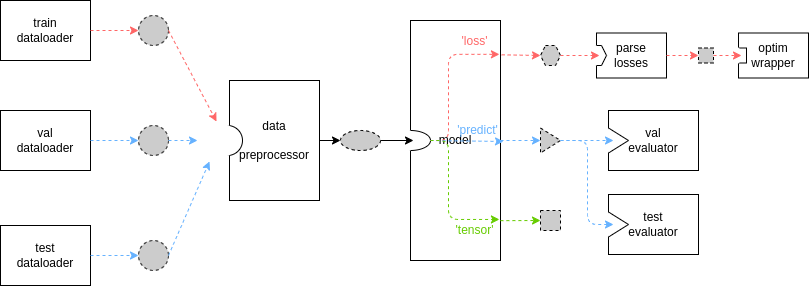